# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.


In [ ]:
import torch
import numpy as np

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [ ]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
class Neuron:

    def __init__(self, in_features):
        self.in_features = in_features
        
        #now it requires grad to ease our code
        self.weights = torch.randn(self.in_features, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.sum(self.weights * inputs) + self.bias


class MSE:
    def forward(self, y_pred, y_true):
        return (y_pred - y_true) ** 2

In [ ]:
neuron = Neuron(X.size(1))
se = MSE()

lr = 0.01
epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)

        loss = se.forward(y_pred, y_true)
        loss.backward()
        
        # do the step
        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.bias.grad
        
        
        # zero grad!!!!!
        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()
    print("epoch", epoch," weights ",neuron.weights)

neuron.weights, coef


epoch 0  weights  tensor([70.0173, 13.3173, 74.0280, 49.1350], requires_grad=True)
epoch 1  weights  tensor([79.2244,  9.7373, 85.9642, 61.7457], requires_grad=True)
epoch 2  weights  tensor([80.7689,  8.4890, 88.6092, 64.6022], requires_grad=True)
epoch 3  weights  tensor([81.0682,  8.1623, 89.2351, 65.2352], requires_grad=True)
epoch 4  weights  tensor([81.1305,  8.0818, 89.3833, 65.3755], requires_grad=True)
epoch 5  weights  tensor([81.1440,  8.0624, 89.4181, 65.4068], requires_grad=True)
epoch 6  weights  tensor([81.1470,  8.0578, 89.4262, 65.4138], requires_grad=True)
epoch 7  weights  tensor([81.1476,  8.0567, 89.4281, 65.4154], requires_grad=True)
epoch 8  weights  tensor([81.1478,  8.0564, 89.4285, 65.4157], requires_grad=True)
epoch 9  weights  tensor([81.1478,  8.0564, 89.4286, 65.4158], requires_grad=True)


(tensor([81.1478,  8.0564, 89.4286, 65.4158], requires_grad=True),
 array([81.14784809,  8.0563676 , 89.4286832 , 65.41584617]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
class Linear:

    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features

        self.weights = torch.randn(out_features, in_features, requires_grad=True)
        self.biases = torch.randn(out_features, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights.T) + self.biases


class MSE:
    def forward(self, y_pred, y_true):
        return torch.mean((y_pred - y_true) ** 2)
    
class ReLU:
    def forward(self, inputs):
        return torch.maximum(inputs, torch.tensor(0))

In [ ]:
y.shape

torch.Size([100, 1])

In [ ]:
fc1 = Linear(X.shape[1], 100)
relu = ReLU()
fc2 = Linear(100, y.shape[1])
mse = MSE()

lr = 0.01
epochs = 1000

losses = torch.empty(epochs)
for epoch in range(epochs):
    
    y_pred = fc2.forward(relu.forward(fc1.forward(X)))

    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    with torch.no_grad():
        fc1.weights -= lr * fc1.weights.grad
        fc1.biases -= lr * fc1.biases.grad
        fc2.weights -= lr * fc2.weights.grad
        fc2.biases -= lr * fc2.biases.grad

    fc1.weights.grad.zero_()
    fc1.biases.grad.zero_()
    fc2.weights.grad.zero_()
    fc2.biases.grad.zero_()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

In [ ]:
import matplotlib.pyplot as plt

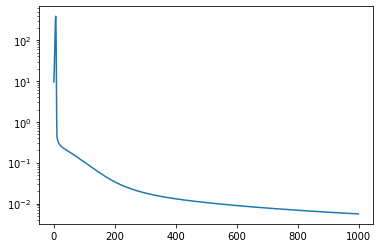

In [ ]:
plt.plot(range(len(losses)),losses.detach().numpy())
plt.yscale("log")

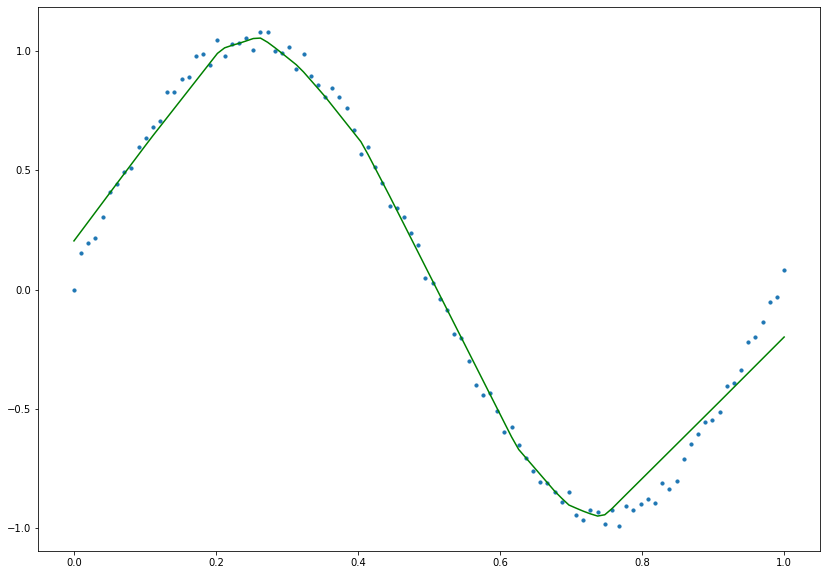

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(X, y, s=10)
plt.plot(X, predicts.detach(), c='g')


## 2. Алгоритмы оптимизации в `torch.optim`

In [ ]:
import torch.optim as optim

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [ ]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [ ]:
neuron = Neuron(X.shape[1])
mse = MSE()

lr = 0.1
params = [neuron.weights, neuron.bias]
optimizer = optim.SGD(params, lr=lr,weight_decay=0.0002)

epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        optimizer.zero_grad()
        y_pred = neuron.forward(x)
        
        #compute loss and calculate grad
        loss = mse.forward(y_pred, y_true)
        loss.backward()
        
        # do the step
        optimizer.step()

neuron.weights, coef


(tensor([17.3980, 71.0933, 37.5655, 35.9532], requires_grad=True),
 array([17.3980905 , 71.10130585, 37.57278426, 35.95549009]))

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [ ]:
torch.manual_seed(0)

fc1 = Linear(X.size(1), 100)
relu = ReLU()
fc2 = Linear(100, y.size(1))
mse = MSE()

lr = 0.01
params = [fc1.weights, fc1.biases, fc2.weights, fc2.biases]
optimizer = optim.Adam(params, lr=lr)

epochs = 1000
losses = torch.empty(epochs)
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = fc2.forward(relu.forward(fc1.forward(X)))
    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    optimizer.step()

predicts = fc2.forward(relu.forward(fc1.forward(X)))

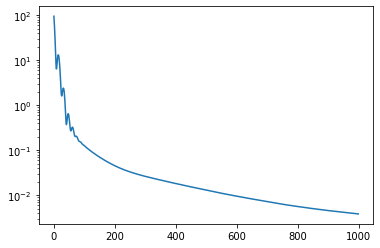

In [ ]:
plt.plot(range(len(losses)),losses.detach().numpy())
plt.yscale("log")

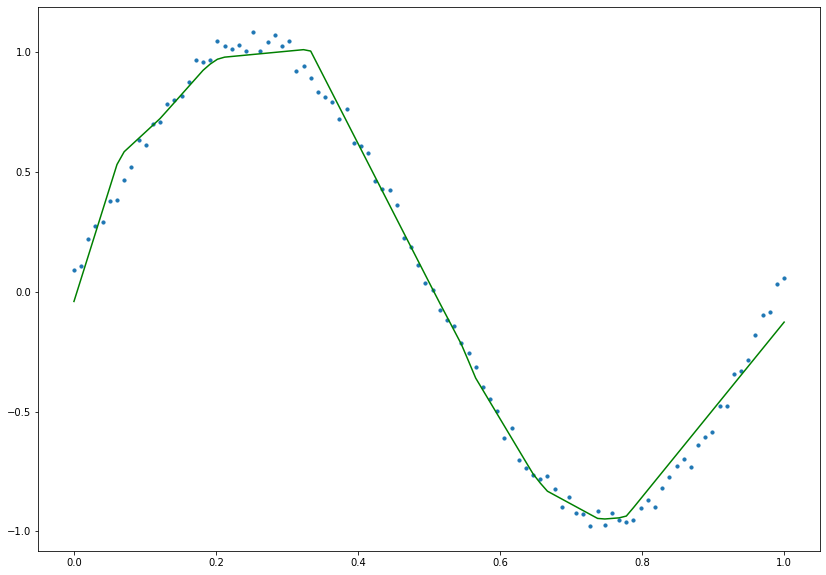

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(X, y, s=10)
plt.plot(X, predicts.detach(), c='g')


## 3. Построение сетей при помощи `torch.nn`

In [ ]:
import torch.nn as nn

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
class Net(nn.Module):
    ##класс сети
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # линейный слой 
        self.fc1 = nn.Linear(self.in_features, 100)
        # РЕЛУ
        self.relu = nn.ReLU()
        # линейный слой 
        self.fc2 = nn.Linear(100, self.out_features)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.fc2(self.relu(self.fc1(inputs)))

In [ ]:
torch.manual_seed(0)

net = Net(X.shape[1], y.shape[1])
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

predicts = net(X)

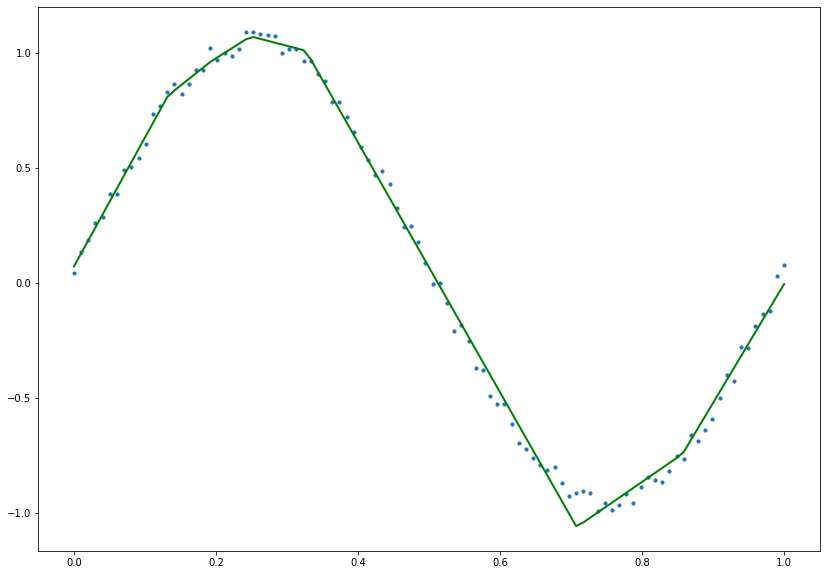

In [ ]:

plt.figure(figsize=(14,10))
plt.scatter(X, y, s=10)
plt.plot(X, predicts.detach(), c='g', lw=2)

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [ ]:
in_features = X.shape[1]
out_features = y.shape[1]

net = nn.Sequential(
    nn.Linear(in_features, 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, out_features),
)
criterion = nn.L1Loss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.95)

In [ ]:
for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

predicts = net(X)

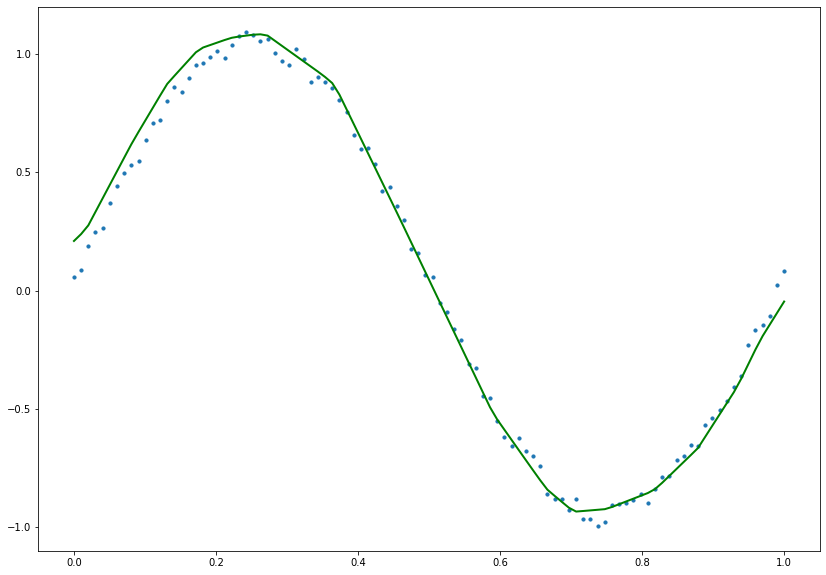

In [ ]:
plt.figure(figsize=(14,10))
plt.scatter(X, y, s=10)
plt.plot(X, predicts.detach(), c='g', lw=2)

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [ ]:
from sklearn import datasets
dataset = datasets.load_breast_cancer()
X = torch.from_numpy(dataset.data).to(torch.float32)
y = torch.from_numpy(dataset.target).to(torch.float32).view(-1, 1)

In [ ]:
def accuracy_score(y_true, y_pred):
    return torch.sum(y_pred == y_true) / y_pred.shape[0]

In [ ]:
from sklearn import metrics

In [ ]:
net = nn.Sequential(
    nn.Linear(X.shape[1], 50),
    nn.ReLU(),
    nn.Linear(50, y.shape[1]),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epochs = 1000
for epoch in range(epochs + 1):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

    if epoch % 200 == 0:
        accuracy = metrics.accuracy_score(y, y_pred.round().detach().numpy())
        print(f"Epoch [{epoch:4}/{epochs}]{' ' * 6}loss = {loss:.5f}, accuracy = {accuracy:.5f}")

Epoch [   0/1000]      loss = 20.00090, accuracy = 0.37258
Epoch [ 200/1000]      loss = 0.15406, accuracy = 0.93673
Epoch [ 400/1000]      loss = 0.11407, accuracy = 0.95079
Epoch [ 600/1000]      loss = 0.09538, accuracy = 0.95606
Epoch [ 800/1000]      loss = 0.08721, accuracy = 0.95958
Epoch [1000/1000]      loss = 0.07757, accuracy = 0.96485


## 4. Datasets and dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [ ]:
class SinDataset(Dataset):
    def __init__(self):
        self.data = torch.linspace(0, 1, 100).view(-1, 1)
        self.target = torch.sin(2 * np.pi * self.data) + 0.1 * torch.rand(self.data.size())

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.data[idx], self.target[idx]

In [ ]:
sin_dataset = SinDataset()
sin_dataloader = DataLoader(sin_dataset, batch_size=10)

X, y = sin_dataset.data, sin_dataset.target

In [ ]:
net = nn.Sequential(
    nn.Linear(X.shape[1], 30),
    nn.ReLU(),
    nn.Linear(30, 100),
    nn.ReLU(),
    nn.Linear(100, y.shape[1]),
)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

In [ ]:
steps = len(sin_dataloader)
epochs = 500
for epoch in range(epochs + 1):
    for i, (x_, y_) in enumerate(sin_dataloader):
        optimizer.zero_grad()

        y_pred = net(x_)
        loss = criterion(y_pred, y_)
        loss.backward()

        optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch:3}     loss = {loss:.5f}")

Epoch   0     loss = 0.39935
Epoch 100     loss = 0.01939
Epoch 200     loss = 0.01205
Epoch 300     loss = 0.00234
Epoch 400     loss = 0.01326
Epoch 500     loss = 0.02092


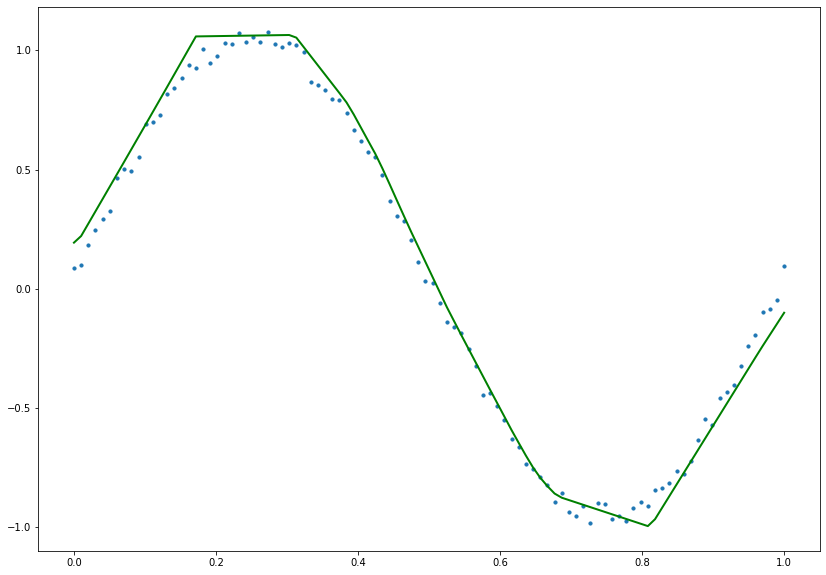

In [ ]:
predicts = net(X)
plt.figure(figsize = (14,10))
plt.scatter(X, y, s=10)
plt.plot(X, predicts.detach(), c='g', lw=2)

4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [ ]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import seaborn as sns

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data):
        data = data.select_dtypes(np.number)
        features = data[data.columns.drop("price")]
        labels = data[["price"]]

        self.features = torch.from_numpy(features.to_numpy(dtype=np.float32))
        self.labels = torch.from_numpy(labels.to_numpy(dtype=np.float32))

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [ ]:
diamonds_data = sns.load_dataset("diamonds", data_home="data/")
diamonds_data.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
dataset = DiamondsDataset(diamonds_data)
dataset.features.shape, dataset.labels.shape

(torch.Size([53940, 6]), torch.Size([53940, 1]))

In [ ]:
# from sklearn.model_selection import random_split

In [ ]:
train_size = round(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, lengths=(train_size, len(dataset) - train_size))

In [ ]:
net = nn.Sequential(
    nn.Linear(dataset.features.shape[1], 100),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.Dropout(0.2),
    nn.ReLU(),
    nn.Linear(50, 32),
    nn.Dropout(0.15),
    nn.ReLU(),
    nn.Linear(32, dataset.labels.shape[1]),
    nn.ReLU(),
)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
net.train() 
train_loader = DataLoader(train_dataset, batch_size=64)

steps = len(train_loader)
epochs = 50
losses = torch.empty(epochs + 1)

for epoch in range(epochs + 1):
    total_loss = 0
    for i, (x_, y_) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = net(x_)
        loss = criterion(y_pred, y_)
        loss.backward()
        optimizer.step()

        total_loss += loss
    if epoch % 5 == 0:
        print(f"Epoch {epoch:4}  loss = {loss:.4f}, R2 = {metrics.r2_score(y_, y_pred.detach().numpy()):.4f}")

    losses[epoch] = total_loss / steps

Epoch    0  loss = 4175755.0000, R2 = 0.1285
Epoch    5  loss = 2154729.7500, R2 = 0.5503
Epoch   10  loss = 1605885.6250, R2 = 0.6648
Epoch   15  loss = 1874485.5000, R2 = 0.6088
Epoch   20  loss = 2360021.0000, R2 = 0.5074
Epoch   25  loss = 2070010.7500, R2 = 0.5680
Epoch   30  loss = 2197501.5000, R2 = 0.5414
Epoch   35  loss = 1755652.1250, R2 = 0.6336
Epoch   40  loss = 2099594.7500, R2 = 0.5618
Epoch   45  loss = 2744867.0000, R2 = 0.4271
Epoch   50  loss = 2609278.0000, R2 = 0.4554


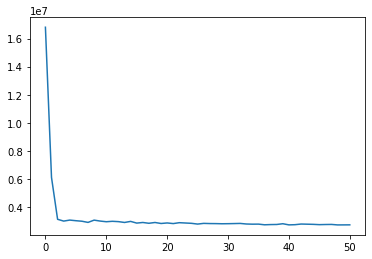

In [ ]:
plt.plot(torch.arange(losses.shape[0]), losses.detach().numpy())

In [ ]:
net.eval()

(X_train, y_train), (X_test, y_test) = train_dataset[:], test_dataset[:]
print(f"R2 (train)",   metrics.r2_score(y_train, net(X_train).detach().numpy()))
print(f"R2 (test)",   metrics.r2_score(y_test, net(X_test).detach().numpy()))

R2 (train) 0.869217699533837
R2 (test) 0.8748639060840429


4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [ ]:
class DiamondsDataset(Dataset):
    def __init__(self, data, transform):
        self.features = data[data.columns.drop("price")]
        self.labels = data[["price"]]
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.features[idx], self.labels[idx]
        if self.transform:
            return self.transform(sample)
        return sample

In [ ]:
class DropColsTransform:
    def __init__(self, drop):
        self.drop = drop

    def __call__(self, sample):
        features, labels = sample
        return features.drop(columns=features.columns[self.drop]), labels

In [ ]:
class ToTensorTransform:
    def __call__(self, sample):
        features, labels = sample
        features = torch.from_numpy(features.to_numpy(dtype=np.float32))
        labels = torch.from_numpy(labels.to_numpy(dtype=np.float32))
        return features, labels

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    DropColsTransform(drop=[1, 2, 3]),
    ToTensorTransform(),
])
dataset = DiamondsDataset(diamonds_data, transform)

In [ ]:
X, y = dataset[:]
X.shape, y.shape

(torch.Size([53940, 6]), torch.Size([53940, 1]))